# Power & Flerfaldig testning

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

np.random.seed(42)

In [11]:
baseline_rate_A = 0.25

min_detectable_diff_pp = 2.0
min_detectable_diff = min_detectable_diff_pp / 100.0

target_rate_B = baseline_rate_A + min_detectable_diff

alpha = 0.05
power_target = 0.80

In [12]:
effect_size = proportion_effectsize(prop1=baseline_rate_A, prop2=target_rate_B)

solver = NormalIndPower()
n_per_group = solver.solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power_target,
    ratio=1.0,
    alternative="two-sided"
)

n_per_group_rounded = int(np.ceil(n_per_group))

effect_size, n_per_group, n_per_group_rounded

(np.float64(-0.04560357707934637), 7548.119854698114, 7549)

In [16]:
def simulate_power(n_per_group, true_p_A, true_p_B, alpha=0.05, n_sims=5000):
    rejections = 0
    for _ in range(n_sims):
        A = np.random.binomial(1, true_p_A, n_per_group)
        B = np.random.binomial(1, true_p_B, n_per_group)
        x_A, x_B = A.sum(), B.sum()
        n_A, n_B = len(A), len(B)
        _, p_val = proportions_ztest(count=[x_A, x_B], nobs=[n_A, n_B], alternative="two-sided")
        rejections += (p_val < alpha)
    return rejections / n_sims

sim_power = simulate_power(n_per_group_rounded, baseline_rate_A, target_rate_B, alpha=alpha, n_sims=3000)
sim_power

np.float64(0.8)

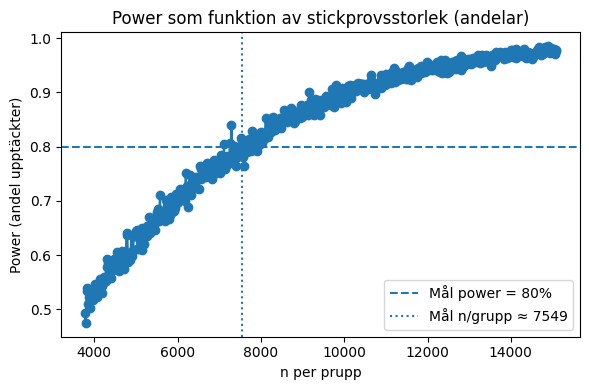

In [ ]:
grid = np.arange(max(50, n_per_group_rounded // 2), n_per_group_rounded * 2 + 1, 20)
power_values = [simulate_power(n, baseline_rate_A, target_rate_B, alpha=alpha, n_sims=1000) for n in grid]

plt.figure(figsize=(6,4))
plt.plot(grid, power_values, marker="o")
plt.axhline(power_target, linestyle="--", label=f"Mål power = {int(power_target*100)}%")
plt.axvline(n_per_group_rounded, linestyle=":", label=f"Mål n/grupp ≈ {n_per_group_rounded}")
plt.title("Power som funktion av stickprovsstorlek (andelar)")
plt.xlabel("n per prupp")
plt.ylabel("Power (andel upptäckter)")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
def pct(x): return f"{x*100:.1f}%"

summary_txt = f"""
Planering (andelar):
- Baslinje A: {pct(baseline_rate_A)}
- Minsta praktiskt viktiga skillnad: +{min_detectable_diff_pp:.1f} pp (-> B = {pct(target_rate_B)})
- Signifikansnivå (alpha): {alpha}
- Målad power: {int(power_target*100)}%
- Beräknat n per grupp: ≈ {n_per_group_rounded}
- Simulerad power vid detta n: ≈ {pct(sim_power)}
"""
print(summary_txt)


Planering (andelar):
- Baslinje A: 25.0%
- Minsta praktiskt viktiga skillnad: +2.0 pp (-> B = 27.0%)
- Signifikansnivå (alpha): 0.05
- Målad power: 80%
- Beräknat n per grupp: ≈ 7549
- Simulerad power vid detta n: ≈ 80.0%



In [21]:
baseline = 0.25
delta = 0.02
B_true = baseline + delta
alpha = 0.05
n_per_group = 7000
ratio = 1.0
alternative = "two-sided"

eff = proportion_effectsize(baseline, B_true)

power = NormalIndPower().power(
    effect_size=eff,
    nobs1=n_per_group,
    alpha=alpha,
    ratio=ratio,
    alternative=alternative
)

n_needed = NormalIndPower().solve_power(
    effect_size=eff,
    alpha=alpha,
    power=0.80,
    ratio=ratio,
    alternative=alternative
)

power, n_needed

(np.float64(0.7697383017252254), 7548.119854698114)

In [26]:
from statsmodels.stats.power import TTestIndPower

mu_A, mu_B = 50, 54               # sanna medel
sd_pooled = 10                    # ungefärlig gemensam standardavvikelse
d = (mu_B - mu_A) / sd_pooled     # Cohen's d
alpha = 0.05
n_per_group = 120                 # planerat n per grupp

power_t = TTestIndPower().power(effect_size=d,
                                nobs1=n_per_group,
                                alpha=alpha,
                                ratio=1.0,
                                alternative="two-sided")

n_needed_t = TTestIndPower().solve_power(effect_size=d,
                                         alpha=alpha,
                                         power=0.80,
                                         ratio=1.0,
                                         alternative="two-sided")

power_t, n_needed_t

(np.float64(0.8698955140303077), 99.08032514658997)

In [27]:
np.random.seed(7)

m = 20 #Antal samtidiga tester

pvals_nulls = np.random.uniform(0, 1, size=15)
pvals_true = np.random.beta(a=0.5, b=20, size=5) * 0.1
pvals = np.concatenate([pvals_nulls, pvals_true])
np.random.shuffle(pvals)

alpha_global = 0.05

reject_fdr, pvals_fdr, _, _ = multipletests(pvals, alpha=alpha_global, method="fdr_bh")

reject_bonf, pvals_bonf, _, _ = multipletests(pvals, alpha=alpha_global, method="bonferroni")

result_df = pd.DataFrame({
    "p_raw": pvals,
    "FDR_reject": reject_fdr,
    "p_adj_FDR": pvals_fdr,
    "Bonf_reject": reject_bonf,
    "p_adj_Bonf": pvals_bonf
}).sort_values("p_raw")

display(result_df.head(10))
print("\nAntal avslag (FDR):", reject_fdr.sum())
print("Antal avslag (Bonferroni):", reject_bonf.sum())

,p_raw,FDR_reject,p_adj_FDR,Bonf_reject,p_adj_Bonf
9,0.001497,True,0.013937,True,0.029934
14,0.001905,True,0.013937,True,0.038105
5,0.002091,True,0.013937,True,0.041812
0,0.003187,True,0.015933,False,0.063734
11,0.007342,True,0.029366,False,0.146831
12,0.065936,False,0.190771,False,1.000000
19,0.072051,False,0.190771,False,1.000000
18,0.076308,False,0.190771,False,1.000000
6,0.268439,False,0.576291,False,1.000000
10,0.288146,False,0.576291,False,1.000000



Antal avslag (FDR): 5
Antal avslag (Bonferroni): 3
